In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import pickle as pkl
import numpy as np
import random
import seaborn as sns
from scipy.stats import gaussian_kde
import os


In [2]:
# Load the data
def load_data(directory, startswith=None):
    data = []

    # Load all pickle files in the directory and append their data to the list
    for filename in os.listdir(directory):
        if filename.endswith('.pkl') and (startswith is None or filename.startswith(startswith)):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'rb') as f:
                data.append(pkl.load(f))


    data_no_advertisers = [
        {
            k: v for k, v in d[0].items() if k != 'advertisers'
        } for d in data
    ]
    all_advertisers = [d[0]['advertisers'] for d in data]

    # Create a dataframe
    df = pd.DataFrame.from_records(data_no_advertisers, index=range(len(data)))
    return df, all_advertisers


In [3]:
df, all_advertisers = load_data('./data/output',
                                startswith='ga_results_b'
                                )

In [4]:
def tau(externality, coeffs):
    tau_val = 0
    for i, coeff in enumerate(coeffs):
        tau_val += coeff * (externality**i)
    return tau_val

def print_tau(coeffs):
    terms = []
    for i, coeff in enumerate(coeffs):
        if i == 0:
            terms.append(f"{coeff:.4f}")
        elif i == 1:
            terms.append(f"{coeff:.4f}*x")
        else:
            terms.append(f"{coeff:.4f}*x^{i}")
    return " + ".join(terms)

def plot_advertisers(auction_output, ad_scaler=1, ext_scaler=1):
    # plot all advertisers and best line
    advertisers = auction_output['advertisers']
    tau_coeffs = auction_output['tau']
    v = [ad[0]*ad_scaler for advertisers_set in advertisers for ad in advertisers_set]
    e = [ad[1]*ext_scaler for advertisers_set in advertisers for ad in advertisers_set]
    min_e, max_e = min(e), max(e)*1.1
    division_size = int(((2*max_e) - min_e) / 100)
    tau_x = [min_e + i*division_size for i in range(100)]
    tau_y = [tau(t, tau_coeffs) for t in tau_x]

    fig, axs = plt.subplots(1, 1, figsize=(10, 5))

    axs.scatter(e, v, alpha=0.5)
    axs.plot(tau_x, tau_y, color='red')
    axs.set_ylabel('Advertiser Value')
    axs.set_xlabel('Externality Value')
    axs.set_title('Social Welfare Values vs Advertiser Values with Best Tau Line')

    # set x and y limits
    axs.set_xlim(min_e, max_e)
    axs.set_ylim(0, max(v)*1.1)
    fig.show()
    
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """Create a new colormap from a subset (minval->maxval) of an existing cmap."""
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Plotting the Data

Desired plots are:
- ~~Ad. welfare from Ext. welfare for each polynomial degree~~
- ~~triplot of change in welfare vs externality cost~~
- ~~example of tau with advertisers~~
- ~~tau from different k and poly but same lambda~~
- ~~histogram distributions of welfare values~~

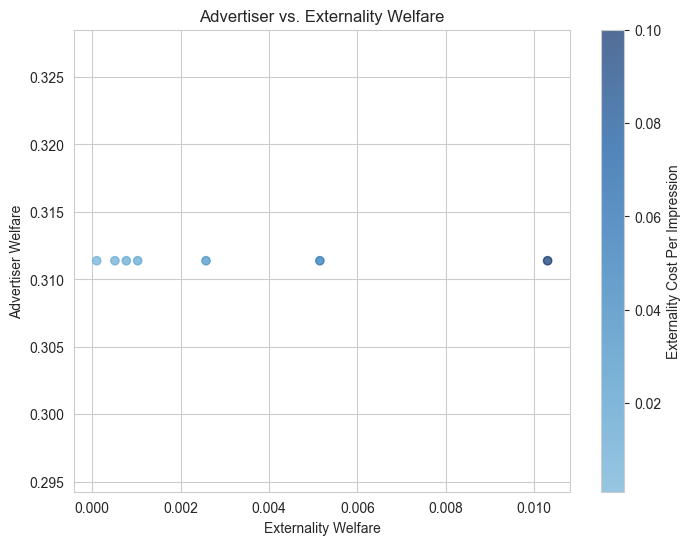

In [5]:
# Plot ad welfare vs ext welfare
df_k_1 = df[df['k'] == 1]

sns.set_style('whitegrid')
# Define a mapping from polynomial_degree to a named colormap
cmap_dict = {
    1: 'Blues',
    2: 'Reds',
    3: 'Greens'
}

original_blues = plt.cm.Blues
short_blues = truncate_colormap(original_blues, minval=0.5, maxval=1.0)


plt.figure(figsize=(8,6))
# We will keep track of the min and max of externality_cost_per_impression
# so that each scatter uses the same color scale
vmin = df['externality_cost_per_impression'].min()
vmax = df['externality_cost_per_impression'].max()

for poly in [1]:#, 2, 3]:
    subset = df_k_1[df_k_1['polynomial_degree'] == poly]
    
    # Plot each subset with its own colormap
    scatter = plt.scatter(
        x=subset['w_coll_ext'],
        y=subset['w_coll_adv'],
        c=subset['externality_cost_per_impression'],
        cmap=short_blues,
        alpha=0.7,  # slightly transparent
        vmin=vmin,  # ensures consistent color scale across subsets
        vmax=vmax,
        label=f'polynomial degree={poly}'
    )
# A single colorbar for all points
cbar = plt.colorbar(scatter, label='Externality Cost Per Impression')

plt.xlabel('Externality Welfare')
plt.ylabel('Advertiser Welfare')
plt.title('Advertiser vs. Externality Welfare')
# plt.legend(title='Tau Polynomial Degree')
# plt.tight_layout()
plt.show()

C:\Users\gabem\AppData\Local\Temp\ipykernel_34832\2071556386.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.sort_values(by='externality_cost_per_impression', inplace=True)
C:\Users\gabem\AppData\Local\Temp\ipykernel_34832\2071556386.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


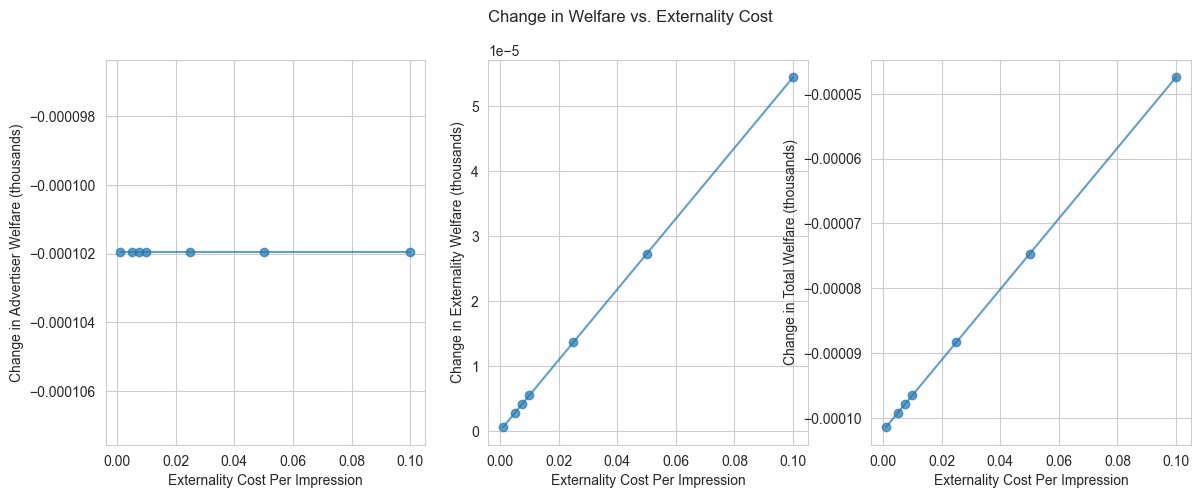

In [6]:
df_k_1['w_adv_change'] = (df_k_1['w_coll_adv'] - df_k_1['w_vcg_adv'])/1000
df_k_1['w_ext_change'] = (df_k_1['w_coll_ext'] - df_k_1['w_vcg_ext'])/1000
df_k_1['w_tot_change'] = (df_k_1['w_coll_tot'] - df_k_1['w_vcg_tot'])/1000

y_labels = ['Change in Advertiser Welfare (thousands)', 'Change in Externality Welfare (thousands)', 'Change in Total Welfare (thousands)']

# three subplots for each change in welfare
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

for i, col in enumerate(['w_adv_change', 'w_ext_change', 'w_tot_change']):
    for poly in [1]:#, 2, 3]:
        subset = df_k_1[df_k_1['polynomial_degree'] == poly]
        subset.sort_values(by='externality_cost_per_impression', inplace=True)
        
        # Plot each subset with its own colormap
        scatter = axs[i].plot(
            subset['externality_cost_per_impression'],
            subset[col],
            marker='o',
            alpha=0.7,  # slightly transparent
            label=f'polynomial degree={poly}',
        )
    axs[i].set_ylabel(y_labels[i])
    axs[i].set_xlabel('Externality Cost Per Impression')

# set figure title
fig.suptitle('Change in Welfare vs. Externality Cost')

# --- Deduplicate handles & labels across subplots ---
# 1. Collect from each axis
handles, labels = [], []
for ax in axs:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# 2. Remove duplicates by zipping into a dict
by_label = dict(zip(labels, handles))

# 3. Create one legend for the figure, using unique labels
# fig.legend(by_label.values(), by_label.keys(), 
#            title='Tau Polynomial Degree', 
#            loc='lower right')
# fig.tight_layout()
fig.show()

Tau Coefficients (degree 1): 2.3043 + -6.4481*x
Tau Coefficients (degree 2): 1.7507 + -4.1103*x + -1.8611*x^2
Tau Coefficients (degree 3): 0.7940 + -0.2049*x + -0.7640*x^2 + -7.0612*x^3


C:\Users\gabem\AppData\Local\Temp\ipykernel_34832\2221360674.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


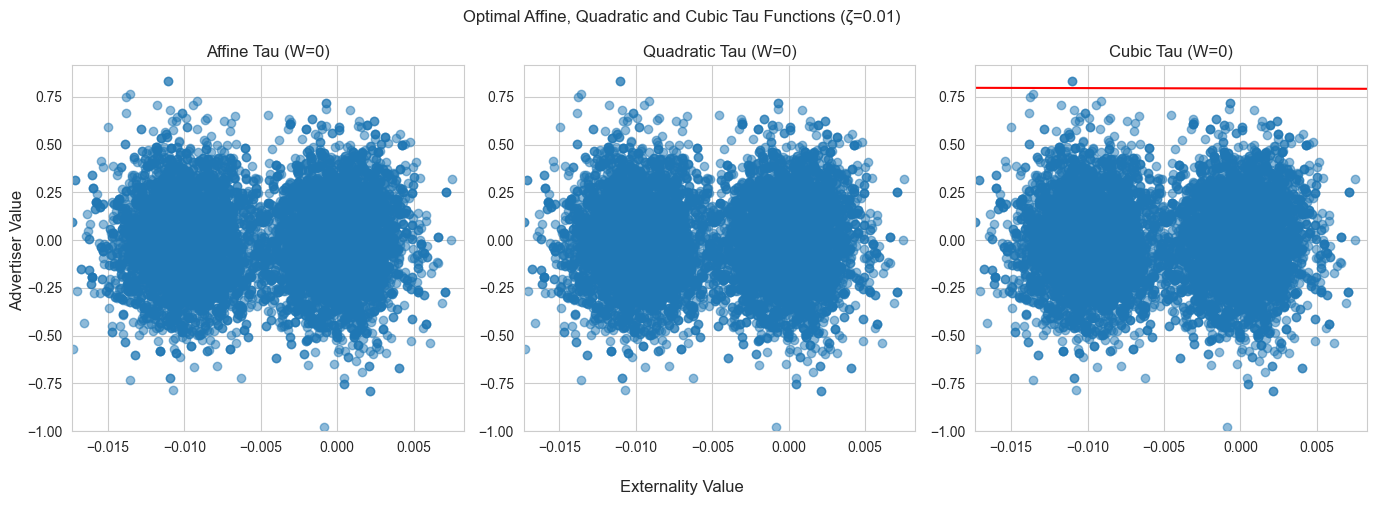

In [8]:
df_for_example_tau = df_k_1[df_k_1['externality_cost_per_impression'] == 0.01]
df_indices = df_for_example_tau.index

# plot advertisers and tau line for each row

titles = ['Affine Tau', 'Quadratic Tau', 'Cubic Tau']
titles = [f'{title} (W={round(df_for_example_tau["w_coll_tot"].iloc[i])})' for i, title in enumerate(titles)]

# three subplots for each change in welfare
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

for i in range(3):
    subset = df_for_example_tau[df_for_example_tau['polynomial_degree'] == i+1]
    advertisers = all_advertisers[df_indices[i]]

    tau_coeffs = subset['tau'].iloc[0]
    print(f'Tau Coefficients (degree {i+1}): {print_tau(tau_coeffs)}')
    
    v = [ad[0] for advertisers_set in advertisers for ad in advertisers_set]
    e = [ad[1] for advertisers_set in advertisers for ad in advertisers_set]
    min_e, max_e = min(e), max(e)*1.1
    division_size = ((2*max_e) - min_e) / 100
    tau_x = [min_e + i*division_size for i in range(100)]
    tau_y = [tau(t, tau_coeffs) for t in tau_x]

    axs[i].scatter(e, v, alpha=0.5)
    axs[i].plot(tau_x, tau_y, color='red')
    # axs[i].set_ylabel('Advertiser Value')
    # axs[i].set_xlabel('Externality Value')
    axs[i].set_title(titles[i])

    # set x and y limits
    axs[i].set_xlim(min_e, max_e)
    axs[i].set_ylim(-1, max(v)*1.1)
    

# set figure title
fig.suptitle('Optimal Affine, Quadratic and Cubic Tau Functions (ζ=0.01)')
fig.supxlabel('Externality Value')
fig.supylabel('Advertiser Value')
fig.tight_layout()
fig.show()




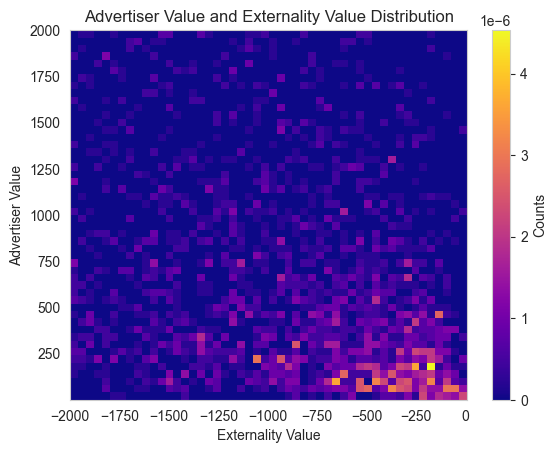

In [27]:
# plot a 2d histogram of the distribution of welfare values
df_for_example_tau = df_k_1[df_k_1['externality_cost_per_impression'] == 0.01]
df_indices = df_for_example_tau.index

advertisers = all_advertisers[df_indices[0]]
    
v = [ad[0] for advertisers_set in advertisers for ad in advertisers_set]
e = [ad[1] for advertisers_set in advertisers for ad in advertisers_set]

# plt.figure(figsize=(8, 8))
plt.hist2d(e, v, 
           bins=(50,50), 
           range=((-2000, 10), (0, 2000)),
           density=True,
           cmap=plt.cm.plasma,
           )
plt.colorbar(label='Counts')
plt.title('Advertiser Value and Externality Value Distribution')
plt.xlabel('Externality Value')
plt.ylabel('Advertiser Value')
plt.xlim(-2000, 10)
plt.ylim(min(v), 2000)
plt.grid(False)

plt.show()

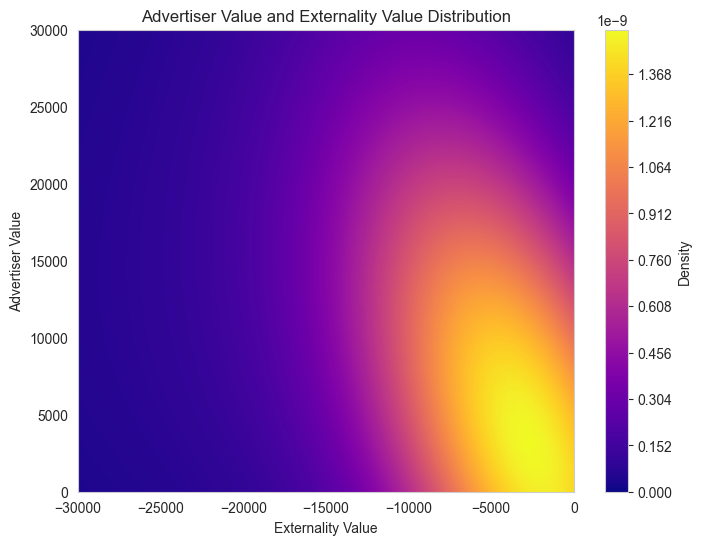

In [12]:
df_for_example_tau = df_k_1[df_k_1['externality_cost_per_impression'] == 0.01]
df_indices = df_for_example_tau.index

advertisers = all_advertisers[df_indices[0]]
    
v = [ad[0] for advertisers_set in advertisers for ad in advertisers_set]
e = [ad[1] for advertisers_set in advertisers for ad in advertisers_set]

x = np.array(e)
y = np.array(v)

# Perform kernel density estimation
xy = np.vstack([x, y])
kde = gaussian_kde(xy)

# Create a grid over the data range
xgrid = np.linspace(x.min(), x.max(), 1000)
ygrid = np.linspace(y.min(), y.max(), 1000)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde(np.vstack([Xgrid.ravel(), Ygrid.ravel()])).reshape(Xgrid.shape)

# Plot contour
plt.figure(figsize=(8, 6))
contour = plt.contourf(Xgrid, Ygrid, Z, levels=1000, cmap='plasma')
plt.colorbar(contour, label='Density')
plt.xlabel('Externality Value')
plt.ylabel('Advertiser Value')
plt.title('Advertiser Value and Externality Value Distribution')
plt.xlim(-30000, 10)
plt.ylim(0, 30000)
plt.savefig('ev_density_plot.png', dpi=600)
plt.show()

In [ ]:
# load k-sweep data
df, all_advertisers = load_data('ga_results_k_2.pkl')
print(df.shape)

In [ ]:

cmap = {1: 'blue', 2: 'red',5: 'orange'}
full_advertisers_set = [ad for advertisers_set in all_advertisers for ad in advertisers_set]

v = [ad[0] for advertisers_set in advertisers for ad in advertisers_set]
e = [ad[1] for advertisers_set in advertisers for ad in advertisers_set]
min_e, max_e = min(e), max(e)*1.1
division_size = int(((2*max_e) - min_e) / 100)
tau_x = [min_e + i*division_size for i in range(100)]

plt.scatter(e, v, alpha=0.5)

for i in range(9):

    tau_coeffs = df['tau'].iloc[i]
    
    tau_y = [tau(t, tau_coeffs) for t in tau_x]

    plt.plot(tau_x, tau_y, color=cmap[df['k'].iloc[i]])

# set x and y limits
plt.xlim(min_e, max_e)
plt.ylim(0, max(v)*1.1)

# Create one custom legend entry per color (k-value)
blue_line  = mlines.Line2D([], [], color='blue',  label='k=1')
red_line   = mlines.Line2D([], [], color='red',   label='k=2')
green_line = mlines.Line2D([], [], color='orange', label='k=5')

plt.legend(handles=[blue_line, red_line, green_line], 
           loc='best', title="Value of k")
    

# set figure title
plt.title('Optimal Tau Functions for Varied K (ζ=0.01)')
plt.xlabel('Externality Value')
plt.ylabel('Advertiser Value')
plt.tight_layout()
plt.show()

## Plotting the Space of Functions Tested

In [9]:
# Load the data
# with open('tested_functions.pkl', 'rb') as f:
#     tested_functions = pkl.load(f)

fns = []
df_for_example_tau = df_k_1[df_k_1['externality_cost_per_impression'] == 0.01]
# Split functions into order 1, 2, and 3
for i in range(3):
    subset = df_for_example_tau[df_for_example_tau['polynomial_degree'] == i+1]
    tested_functions = subset['tested_functions'].iloc[0]
    fns.append(tested_functions)
# order_1 = [f for f in tested_functions if len(f) == 2]
# order_2 = [f for f in tested_functions if len(f) == 3]
# order_3 = [f for f in tested_functions if len(f) == 4]

# fns = [order_1, order_2, order_3]

C:\Users\gabem\AppData\Local\Temp\ipykernel_34832\765607476.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend(loc='upper right')


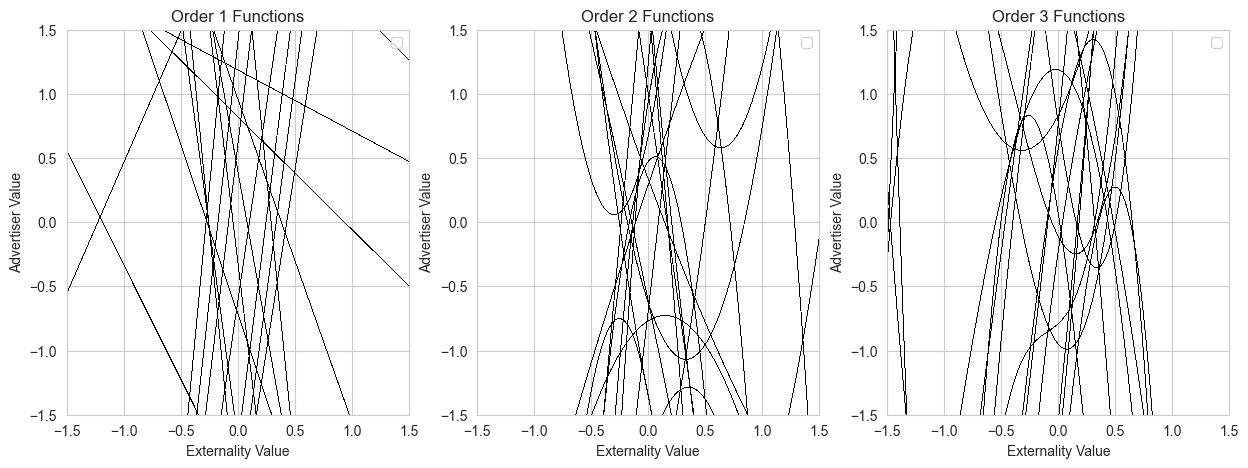

In [15]:


# Create a grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# Plot each order of function
x = np.linspace(-1.5, 1.5, 200)

for i, order in enumerate(fns):
    for fn in order:
        y = np.polyval(list(reversed(fn)), x)
        axs[i].plot(x, y, color="black", alpha=0.05, linewidth=0.05)

    axs[i].set_title(f'Order {i+1} Functions')
    axs[i].set_xlabel('Externality Value')
    axs[i].set_ylabel('Advertiser Value')
    # set x and y limits
    axs[i].set_xlim(-1.5, 1.5)
    axs[i].set_ylim(-1.5, 1.5)
    axs[i].grid(True)
    axs[i].legend(loc='upper right')